# 第一題[分類器、特徵建構、與Stacking]

## Data Preparation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd

In [2]:
f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

In [3]:
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})

## Q1.1

In [4]:
name_df_train = name_df[name_df['fold'] <= 6][['sex', 'fold', 'name']]
name_df_not_train = name_df[name_df['fold'] > 6][['sex', 'fold', 'name']]

In [5]:
name = np.array(name_df_train.loc[:,"name"])
name1 = list()
features = list()

for i in range(len(name)):
    name1.append(name[i])
    name1.append(name[i][0])
    name1.append(name[i][-1])

for element in name1:
    if element not in features:
        features.append(element)

In [6]:
name_df_train[features] = np.NaN
name_df_train['_Other_Feature_'] = np.NaN
name_df_train = name_df_train.fillna(0).set_index('name')
name_df_not_train = name_df_not_train.set_index('name')

In [7]:
for i in range(name_df_train.shape[0]):
    if len(name_df_train.index[i]) == 2:
        if name_df_train.index[i][0] != name_df_train.index[i][1]:
            name_df_train.loc[name_df_train.index[i], name_df_train.index[i]] = 1
            name_df_train.loc[name_df_train.index[i], name_df_train.index[i][0]] = 1
            name_df_train.loc[name_df_train.index[i], name_df_train.index[i][1]] = 1
        else:  # 名字是疊字的
            name_df_train.loc[name_df_train.index[i], name_df_train.index[i]] = 1
            name_df_train.loc[name_df_train.index[i], name_df_train.index[i][0]] = 2
    else:
        name_df_train.loc[name_df_train.index[i], name_df_train.index[i]] = 1

name_df_train['_Other_Feature_'] = 1.0
name_df_train = name_df_train.loc[:, name_df_train.sum(0)>1]

# 篩完之後把名字是疊字的調回1
for i in range(name_df_train.shape[0]):
    if len(name_df_train.index[i]) == 2:
        if name_df_train.index[i][0] == name_df_train.index[i][1]:
            name_df_train.loc[name_df_train.index[i], name_df_train.index[i][0]] = 1

# 調整 '_Other_Feature_' 
for i in range(name_df_train.shape[0]):
    if name_df_train.index[i] in name_df_train.columns:
        name_df_train.iloc[i,-1] = 0

In [8]:
name_df = pd.concat([name_df_train, name_df_not_train], axis=0)
name_df = name_df.fillna(0)

for i in range(name_df_train.shape[0], name_df.shape[0]):
    if len(name_df.index[i]) == 2:
        # 配合train的feature
        if name_df.index[i] in name_df_train.columns:
            name_df.loc[name_df.index[i], name_df.index[i]] = 1
        if name_df.index[i][0] in name_df_train.columns:
            name_df.loc[name_df.index[i], name_df.index[i][0]] = 1
        if name_df.index[i][1] in name_df_train.columns:
            name_df.loc[name_df.index[i], name_df.index[i][1]] = 1
    else:
        if name_df.index[i] in name_df_train.columns:
            name_df.loc[name_df.index[i], name_df.index[i]] = 1
            
name_df.iloc[name_df_train.shape[0]:,-1] = 1.0

# 調整 '_Other_Feature_' 
for i in range(name_df.shape[0]):
    if name_df.index[i] in name_df.columns:
        name_df.iloc[i,-1] = 0

In [9]:
x_train = name_df[name_df['fold']<=6].drop(['sex','fold'], axis=1)
y_train = name_df[name_df['fold']<=6]['sex']
x_valid = name_df[name_df['fold']==7].drop(['sex','fold'], axis=1)
y_valid = name_df[name_df['fold']==7]['sex']
x_stack = name_df[name_df['fold']==8].drop(['sex','fold'], axis=1)
y_stack = name_df[name_df['fold']==8]['sex']
x_test = name_df[name_df['fold']==9].drop(['sex','fold'], axis=1)
y_test = name_df[name_df['fold']==9]['sex']

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_stack.shape)
print(y_stack.shape)
print(x_test.shape)
print(y_test.shape)

(7483, 1630)
(7483,)
(1110, 1630)
(1110,)
(1073, 1630)
(1073,)
(1064, 1630)
(1064,)


## Q1.2

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [12]:
c_space = np.logspace(-4, 3, 20)
scores = []

for c in c_space:
    clf = LogisticRegression(C=c, max_iter=1000).fit(x_train, y_train)
    preds = clf.predict(x_valid)
    scores.append(f1_score(preds, y_valid))
#     print(f1_score(preds, y_valid))

bestc = c_space[scores.index(max(scores))]
best_score_ = max(scores)

In [13]:
print('Regularization Coefficient =', bestc)
print("It's F-1 Score =", best_score_)

Regularization Coefficient = 78.47599703514607
It's F-1 Score = 0.8981132075471698


In [14]:
x_train_valid = pd.concat([x_train, x_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)

clf = LogisticRegression(C=78, max_iter=1000).fit(x_train_valid, y_train_valid)
ypred = clf.predict(x_test)
print('Accuracy:', accuracy_score(ypred, y_test))
print('Precision:', precision_score(ypred, y_test))
print('Recall:', recall_score(ypred, y_test))
print('F-1 Score:', f1_score(ypred, y_test))

Accuracy: 0.8843984962406015
Precision: 0.893223819301848
Recall: 0.8596837944664032
F-1 Score: 0.8761329305135951


In [15]:
coef = clf.coef_[0].tolist()
features = x_train_valid.columns.tolist()
coef_features = zip(coef, features)
sort_coef_features = sorted(coef_features, key=lambda x:abs(x[0]), reverse=True)
# print(list(sort_coef_features))

for i in range(20):
    print(list(sort_coef_features)[i][1], list(sort_coef_features)[i][0])

傑 9.259544242421281
森 8.688171092799035
玲 -8.623480504937191
雯 -8.467345269071162
凌 -8.434214799655447
婷 -8.383147434225181
美 -8.302779084017073
萱 -8.279638654431793
鋒 8.206549353221575
薇 -8.201185894598785
妤 -8.160470660669278
婕 -8.136834875169733
綾 -8.118614060537324
潔 -8.022503661284176
嵐 -7.856724907675149
絃 -7.838120004405167
卉 -7.795481960818359
靜 -7.643198896170248
松 7.604642799347418
蓉 -7.588066242544724


### Q1.2 Conclusion
1. 正數代表是男生，負數代表是女生。
2. 男性傾向的字的依序是: 傑、森、鋒、松；女性傾向的字的依序是: 玲、雯、凌、婷。
3. 從排行榜前20名可以看出女性特徵的字(16個)遠多於男性。
4. Performance Score的表現上普遍還不錯，Recall稍低一點。

## Q1.3

In [16]:
import math
from sklearn.ensemble import RandomForestClassifier

In [17]:
rfc_space_temp = np.logspace(math.log(5,10), 3, 10)
rfc_space = []
for ele in rfc_space_temp:
    rfc_space.append(round(ele))

scores = []

for n in rfc_space:
    rfc = RandomForestClassifier(n_estimators=n).fit(x_train, y_train)
    preds = rfc.predict(x_valid)
    scores.append(f1_score(preds, y_valid))
#     print(f1_score(preds, y_valid))

best_nest = rfc_space[scores.index(max(scores))]
rfc_best_score_ = max(scores)

In [18]:
print('Best Nest =', best_nest)
print("It's F-1 Score =", rfc_best_score_)

Best Nest = 95
It's F-1 Score = 0.8729703915950334


In [19]:
rfc = RandomForestClassifier(n_estimators=best_nest, n_jobs=-1).fit(x_train_valid, y_train_valid)
ypred_rfc = rfc.predict(x_test)
print('Accuracy:', accuracy_score(ypred_rfc, y_test))
print('Precision:', precision_score(ypred_rfc, y_test))
print('Recall:', recall_score(ypred_rfc, y_test))
print('F-1 Score:', f1_score(ypred_rfc, y_test))

Accuracy: 0.8430451127819549
Precision: 0.839835728952772
Recall: 0.821285140562249
F-1 Score: 0.8304568527918782


In [20]:
feature_importances = rfc.feature_importances_.tolist()
features_rank = zip(feature_importances, features)
top_features = sorted(features_rank, key=lambda x:x[0], reverse=True)

for i in range(20):
    print(list(top_features)[i][1], list(top_features)[i][0])

妤 0.01858346270109648
翔 0.015149811938961035
萱 0.013872712057194406
柏 0.013706973131000482
婷 0.012804116123977544
怡 0.009141455314067964
哲 0.00890494690256172
雅 0.008829917744699321
蓁 0.00851108302912227
佳 0.00849571859407354
芷 0.008491802930728853
承 0.008341111733709427
晴 0.00822838180521204
柔 0.00805504887069611
芸 0.008036233403549276
宜 0.007981956829749639
庭 0.007826335388854034
_Other_Feature_ 0.0077479008501017835
涵 0.007677877190950027
瑄 0.007529195493396295


### Q1.3 Conclusion
1. 重要性的排行可以發現說榜上大多數還是女生的字(15個)，推測特定字一出來就能夠強烈指示出女性。
2. 這裡的各項指標都比Q1.2還低，剛好Recall的分數也是最低。

## Q1.4

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
learning_rate = [0.1, 0.5, 1]
scores = []

for lr in learning_rate:
    gbc1 = GradientBoostingClassifier(n_estimators=1500, learning_rate=lr).fit(x_train, y_train)
    staged = gbc1.staged_predict(x_valid)
    score = []
    for pred in staged:
        score.append(f1_score(pred,y_valid))
    scores.append(score)

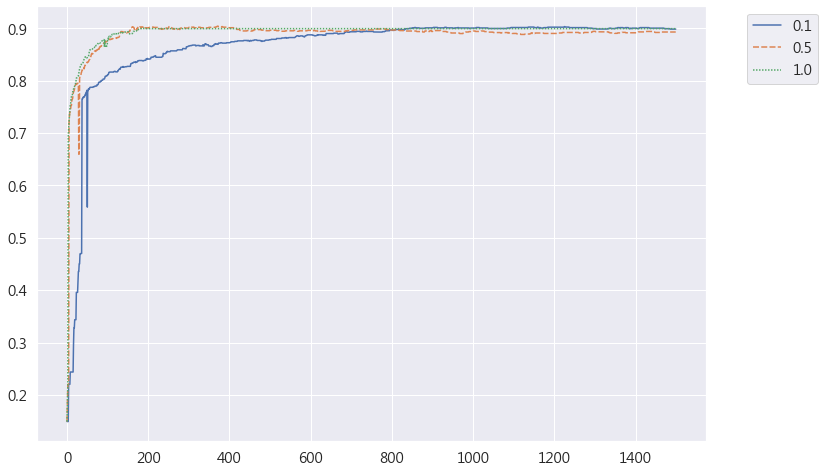

In [64]:
import seaborn as sns
sns.set(style='darkgrid', font='Microsoft JhengHei', rc={'figure.figsize':(12, 8)}, font_scale=1.3)

scores_pd = pd.DataFrame(scores).T
scores_pd.columns = learning_rate

sns.lineplot(data=scores_pd)\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [23]:
maxf1 = []
maxf1_loc = []

for s in scores:
    maxf1.append(max(s))
    maxf1_loc.append(s.index(max(s)))

for i in range(3):
    print('LR =', learning_rate[i],'has best F-1 score =', maxf1[i], 'when stage =', maxf1_loc[i]+1)

LR = 0.1 has best F-1 score = 0.9031657355679703 when stage = 1226
LR = 0.5 has best F-1 score = 0.9040074557315936 when stage = 371
LR = 1 has best F-1 score = 0.900375939849624 when stage = 190


In [24]:
best_lr = 0.5
best_nstg = 314
gbc = GradientBoostingClassifier(n_estimators=1500, learning_rate=best_lr).fit(x_train_valid, y_train_valid)
ypred_gbc = gbc.predict(x_test)
print('Accuracy:', accuracy_score(ypred_gbc, y_test))
print('Precision:', precision_score(ypred_gbc, y_test))
print('Recall:', recall_score(ypred_gbc, y_test))
print('F-1 Score:', f1_score(ypred_gbc, y_test))

Accuracy: 0.881578947368421
Precision: 0.9014373716632443
Recall: 0.8491295938104448
F-1 Score: 0.8745019920318725


In [25]:
feature_importances_gbc = gbc.feature_importances_.tolist()
features_rank_gbc = zip(feature_importances_gbc, features)
top_features_gbc = sorted(features_rank_gbc, key=lambda x:x[0], reverse=True)

for i in range(20):
    print(list(top_features_gbc)[i][1], list(top_features_gbc)[i][0])

妤 0.024594223469569187
翔 0.0182496054958344
柏 0.017272750721676007
萱 0.016640763451627516
婷 0.015824768980568803
承 0.011278550428646178
哲 0.01077505369916394
蓁 0.010720559286773883
宜 0.010660251632463735
佳 0.010462529625947353
怡 0.010189710702696766
晴 0.00988106089114037
柔 0.009471299807779299
雅 0.00943313161639469
瑄 0.009316086199146693
涵 0.00912595001619236
芷 0.00906288377971195
芸 0.0089495920951018
庭 0.008707034484956125
瑜 0.008439772204305657


### Q1.4 Conclusion
1. 重要性的排行可以發現說榜上大多數還是女生的字(16個)，推測特定字一出來就能夠強烈指示出女性。
2. Precision的分數高達0.9，是三個方法中最低的，而Recall仍然是最低，推測本資料集的Recall容易比較低。

## Q1.5

In [11]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

x_train_valid = pd.concat([x_train, x_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)

estimators = [
    ('clf', LogisticRegression()),
    ('rfc', RandomForestClassifier()),
    ('gbf', GradientBoostingClassifier())]

clf = StackingClassifier(
    estimators=estimators, stack_method='predict_proba', final_estimator=LogisticRegression())

clf.fit(x_train_valid , y_train_valid)
ypred_stack = clf.predict(x_test)
print('Accuracy:', accuracy_score(ypred_stack, y_test))
print('Precision:', precision_score(ypred_stack, y_test))
print('Recall:', recall_score(ypred_stack, y_test))
print('F-1 Score:', f1_score(ypred_stack, y_test))

Accuracy: 0.8834586466165414
Precision: 0.9014373716632443
Recall: 0.8524271844660194
F-1 Score: 0.87624750499002


In [12]:
coef = clf.final_estimator_.coef_
a = ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier']
for i in range(3):
    print(a[i], '=', coef[0][i])

LogisticRegression = 8.534320925109684
RandomForestClassifier = -0.17720321566471178
GradientBoostingClassifier = -0.25607460440029833


### Q1.5 Conclusion
1. 從係數來看可以發現LogisticRegression的係數最大。其實蠻合理的，因為預設的final_estimator_就是LogisticRegression()
2. 觀察Metric的表現可以發現其Precision能夠跟GBC一樣來到9字頭，但同時Recall又比GBC高，保持原本LogisticRegression的水準。
3. 我們也可以透過這資料可以知道普遍「女性特定字」的強度大於「男性特定字」。

# 第二題[Data Visualization via Dimensionality Reduction]

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Data Preparation

In [27]:
stu_adm = pd.read_csv('ds/student_admission106.csv', encoding="utf-8", dtype=str)
uname = pd.read_csv('ds/univ_name106short1.csv', encoding="utf-8", dtype=str)

In [28]:
stu_adm.head()

,school_id,department_id,student_id,student_name,state,location1,location2
0,001,001012,10246842,黃士玹,正1,南部,台南考區
1,001,001012,10042237,黃冠婷,正2,北部,台北考區
2,001,001012,10008031,鍾大方,正3,北部,台北考區
3,001,001012,10201525,曾信豪,正4,中部,彰化考區
4,001,001012,10014615,陳品儒,正5,北部,台北考區


In [29]:
uname.head()

,year,school_id,department_id,school_name,department_name,category_id,category_name,school_name_abbr,department_name_abbr
0,106,006,006042,國立政治大學,教育學系,1,教育,政大,教育
1,106,006,006052,國立政治大學,教育學系(公費生),1,教育,政大,教育(公)
2,106,006,006062,國立政治大學,教育學系(原住民公費生),1,教育,政大,教育(原住民)
3,106,006,006022,國立政治大學,歷史學系,2,藝術及人文,政大,歷史
4,106,006,006152,國立政治大學,民族學系,2,藝術及人文,政大,民族學


In [30]:
# matrix of department-student
dep_stu = pd.pivot_table(stu_adm.loc[:,['department_id','student_id']],
                        index='department_id',
                        columns='student_id',
                        fill_value=0,
                        aggfunc=len)
dep_stu.head()

student_id,10000101,10000106,10000110,10000111,10000112,10000114,10000116,10000120,10000121,10000123,...,NTU0604948,NTU0604951,NTU0604964,NTU0604970,NTU0604975,NTU0604991,NTU0604992,NTU0604995,NTU0605007,NTU0605019
department_id,,,,,,,,,,,,,,,,,,,,,
001012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
"""
To avoid potential numerical problems, 
we only include an academic department if it received ten or more applications. 
Moreover, we only include a student applicant if he or she applied for more than one academic department.
"""
while dep_stu.shape != dep_stu.loc[dep_stu.sum(1) > 10, dep_stu.sum(0) > 1].shape:
    dep_stu = dep_stu.loc[dep_stu.sum(1) > 10, dep_stu.sum(0) > 1]

dep_stu.head()

student_id,10000101,10000110,10000111,10000112,10000114,10000116,10000120,10000121,10000125,10000126,...,19710702,19710703,19710708,19710709,19770103,19810104,19810201,19810202,19840201,19950101
department_id,,,,,,,,,,,,,,,,,,,,,
001012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001042,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Q2.1
Visualize academic departments using the first eight principal components. Use your judgment to select multiple pairs of principal components to visualize. Discuss the visual patterns concerning department categories.

In [32]:
dep_category = dep_stu.merge(uname.loc[:,['department_id','category_name']], how='inner', on='department_id')
dep_category = dep_category.loc[:,['department_id','category_name']]
dep_category.head()

,department_id,category_name
0,001012,藝術及人文
1,001022,藝術及人文
2,001032,藝術及人文
3,001042,藝術及人文
4,001052,藝術及人文


In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=8)
dep_stu_pca = pca.fit_transform(dep_stu)
dep_stu_pca = pd.DataFrame(dep_stu_pca)
dep_stu_pca.head()

,0,1,2,3,4,5,6,7
0,-0.031530,-0.011871,-0.183195,-0.039455,0.095678,-0.045154,-0.105230,-0.002785
1,0.196439,-0.011582,-0.238587,-0.066109,0.153547,-0.045437,-0.291834,-0.147244
2,-0.037188,-0.012145,-0.208520,-0.058904,0.086182,-0.027044,-0.125898,-0.026921
3,0.004377,-0.019437,-0.166546,-0.052388,0.062291,-0.024349,-0.100847,0.017324
4,-0.015054,-0.001889,-0.154065,-0.033694,0.073031,-0.036360,-0.087861,0.012239


In [34]:
dep_stu_pca_cat = pd.concat([dep_stu_pca, dep_category.loc[:,'category_name']], axis=1)\
    .set_axis(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'category_name'], axis=1, inplace=False)
dep_stu_pca_cat

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,category_name
0,-0.031530,-0.011871,-0.183195,-0.039455,0.095678,-0.045154,-0.105230,-0.002785,藝術及人文
1,0.196439,-0.011582,-0.238587,-0.066109,0.153547,-0.045437,-0.291834,-0.147244,藝術及人文
2,-0.037188,-0.012145,-0.208520,-0.058904,0.086182,-0.027044,-0.125898,-0.026921,藝術及人文
3,0.004377,-0.019437,-0.166546,-0.052388,0.062291,-0.024349,-0.100847,0.017324,藝術及人文
4,-0.015054,-0.001889,-0.154065,-0.033694,0.073031,-0.036360,-0.087861,0.012239,藝術及人文
...,...,...,...,...,...,...,...,...,...
1907,-0.076466,-0.008627,-0.120240,-0.071394,0.049159,-0.001299,-0.145738,0.038617,醫藥衛生及社會福利
1908,-0.086520,-0.010646,-0.135844,-0.081292,-0.055133,-0.042265,-0.090389,0.011693,醫藥衛生及社會福利
1909,-0.094613,-0.012454,-0.138636,0.010919,-0.104092,0.013656,-0.060198,0.015037,醫藥衛生及社會福利
1910,-0.085681,-0.013642,-0.088388,-0.086129,-0.026459,-0.071243,0.054423,-0.022195,工程、製造及營建


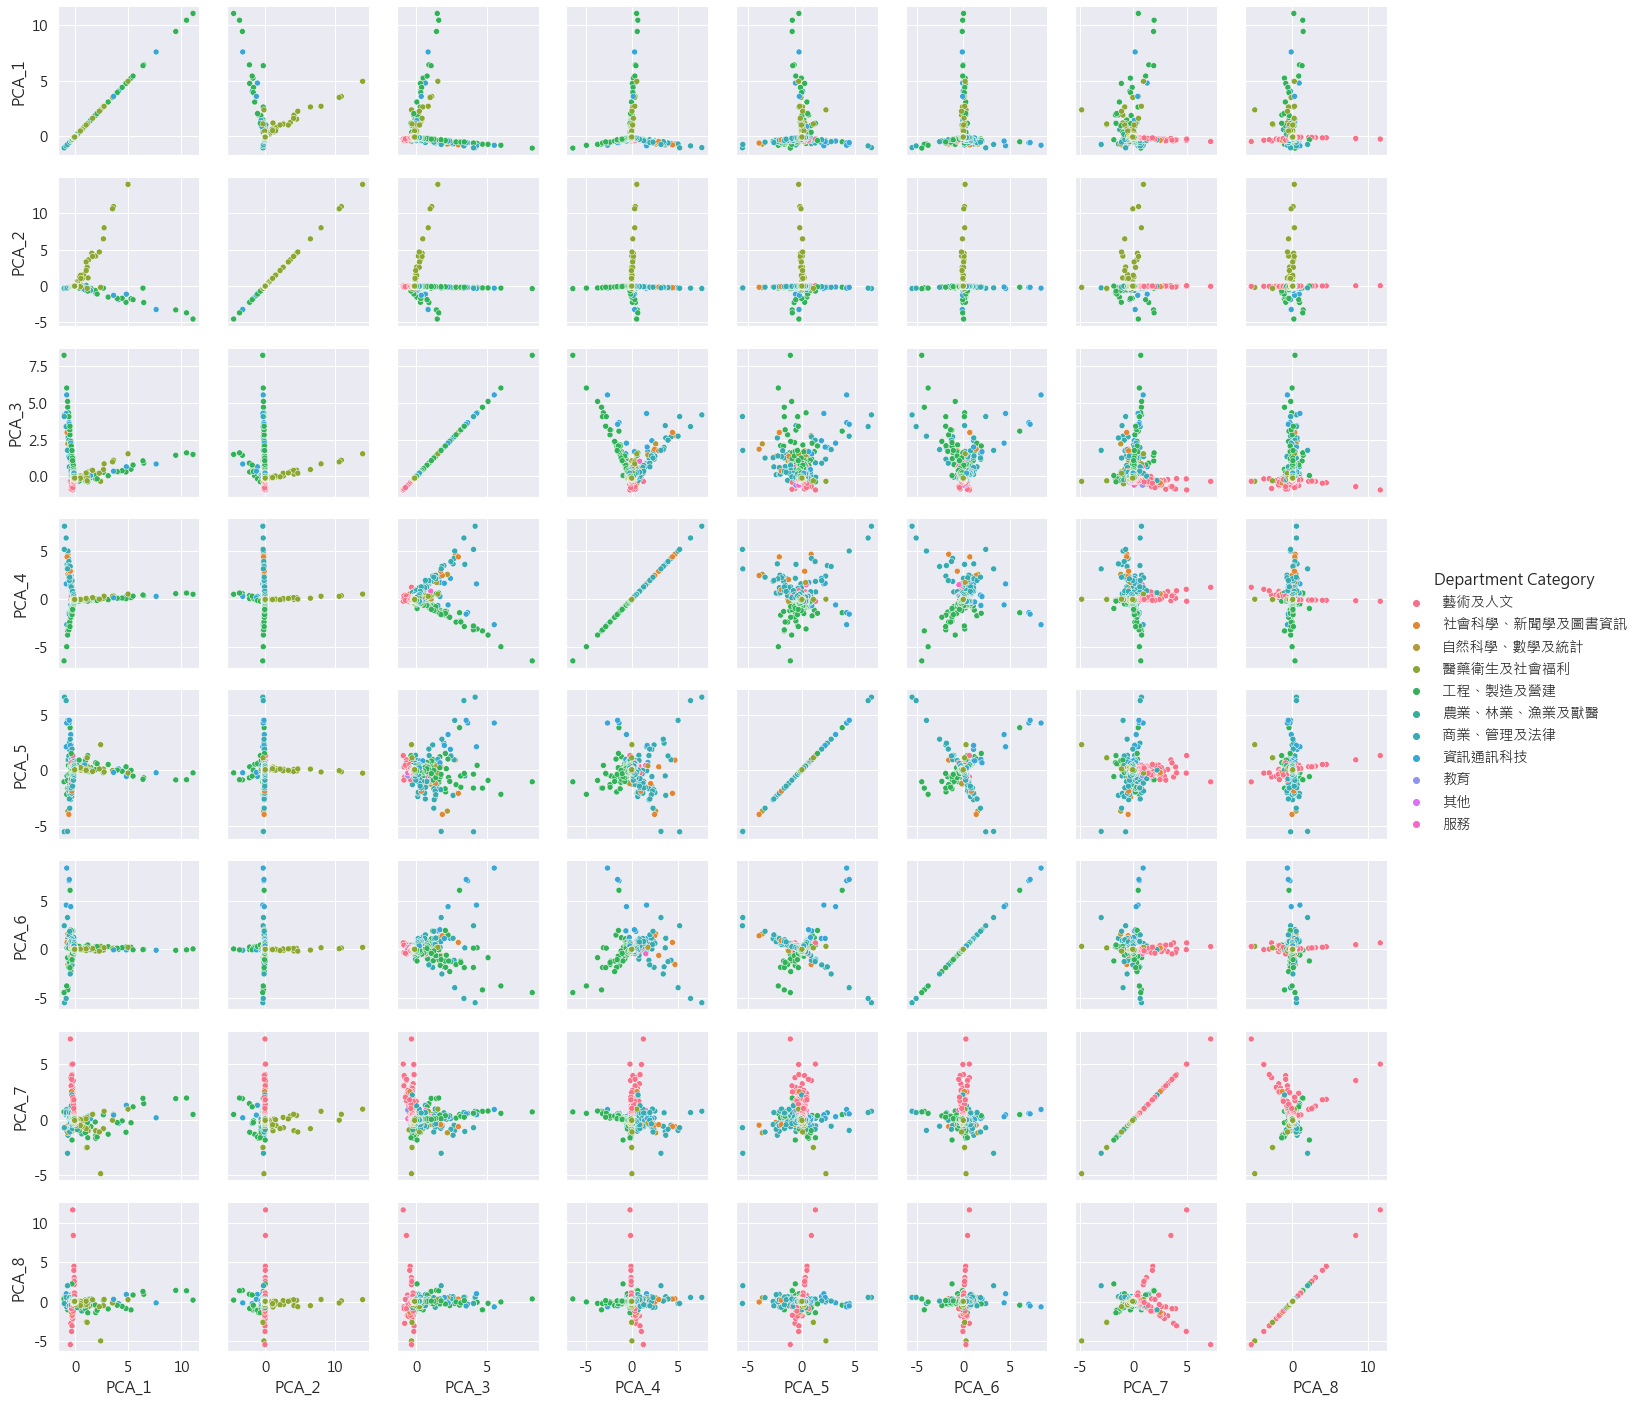

In [35]:
sns.set(style='darkgrid', font='Microsoft JhengHei', rc={'figure.figsize':(12, 8)}, font_scale=1.3)
plt.rcParams['axes.unicode_minus']=False

g = sns.PairGrid(dep_stu_pca_cat, hue='category_name')
g.map(sns.scatterplot)
g.add_legend(title='Department Category')

### Q2.1 Conclusion
1. 這裡我把八種主成分交叉配對可以得到8*8=64張圖。
2. 大多數的圖都是重疊在一起，但仍可以知道有少部分的學群較集中，如「工程、製造及營建」和「醫藥衛生及社會福利」

## Q2.2 
Visualize academic departments using multiple dimensional scaling. Consider both the metric and non-metric settings. Discuss the result. 

In [36]:
from sklearn.manifold import MDS

### Metric

In [37]:
mds = MDS(n_components=2, n_jobs=-1).fit_transform(dep_stu)

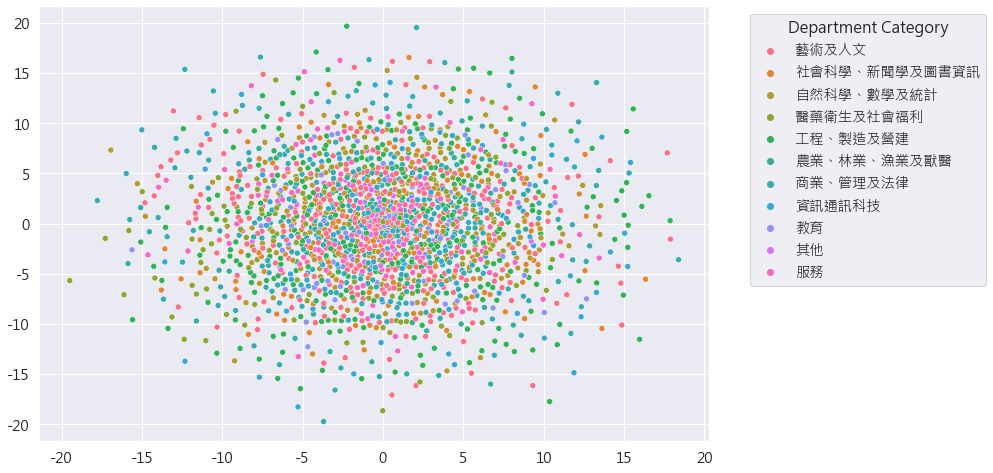

In [38]:
sns.scatterplot(x=mds[:,0], y=mds[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### Non-Metric

In [39]:
non_mds = MDS(n_components=2, metric=False, n_jobs=-1).fit_transform(dep_stu)

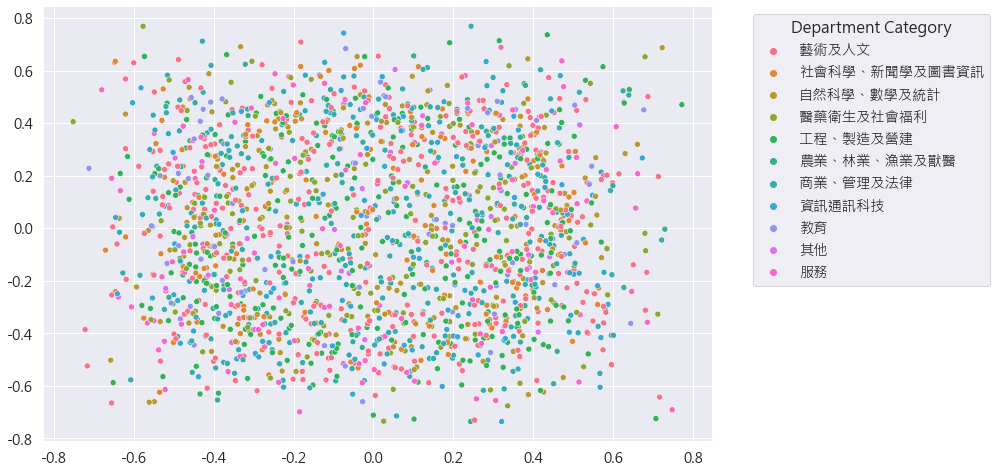

In [40]:
sns.scatterplot(x=non_mds[:,0], y=non_mds[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### Q2.2 Conclusion
1. 使用Metric時圖形主要成橢圓狀，中心比較聚集、外面發散。 
2. 使用Non-Metrix時圖形就比較四散在各地，沒有像Metrix有一個特定的圖形。
3. 可以發現在本資料集不太適合使用MDS，沒有特別的群聚。

## Q2.3
Visualize academic departments using Locally Linear Embedding. Consider three variations: (1) Use 20 neighbors to construct the weight matrix; (2) Use 40 neighbors to construct the weight matrix; (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors). Discuss the result.

In [41]:
from sklearn.manifold import LocallyLinearEmbedding

### (1) Use 20 neighbors to construct the weight matrix

In [42]:
dep_stu_lle_20 = LocallyLinearEmbedding(n_neighbors=20, n_jobs=-1).fit_transform(dep_stu)

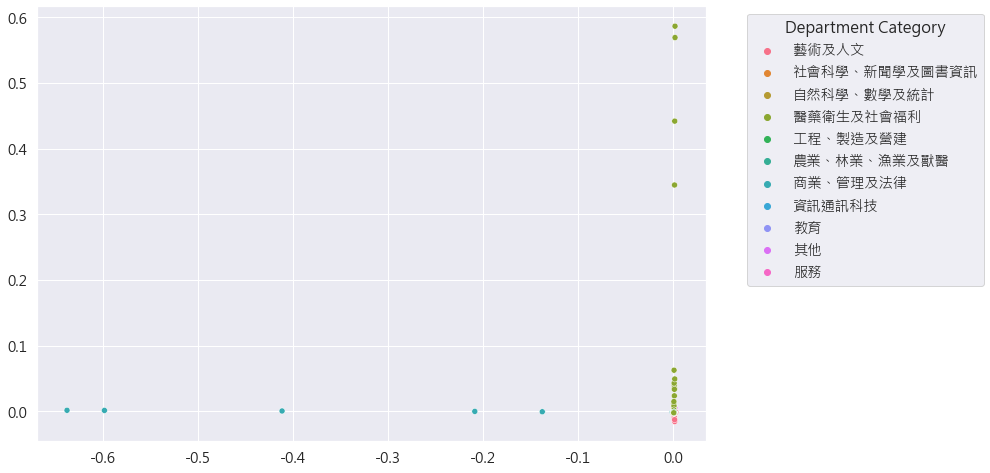

In [43]:
sns.scatterplot(x=dep_stu_lle_20[:,0], y=dep_stu_lle_20[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### (2) Use 40 neighbors to construct the weight matrix

In [62]:
dep_stu_lle_40 = LocallyLinearEmbedding(n_neighbors=40, n_jobs=-1).fit_transform(dep_stu)

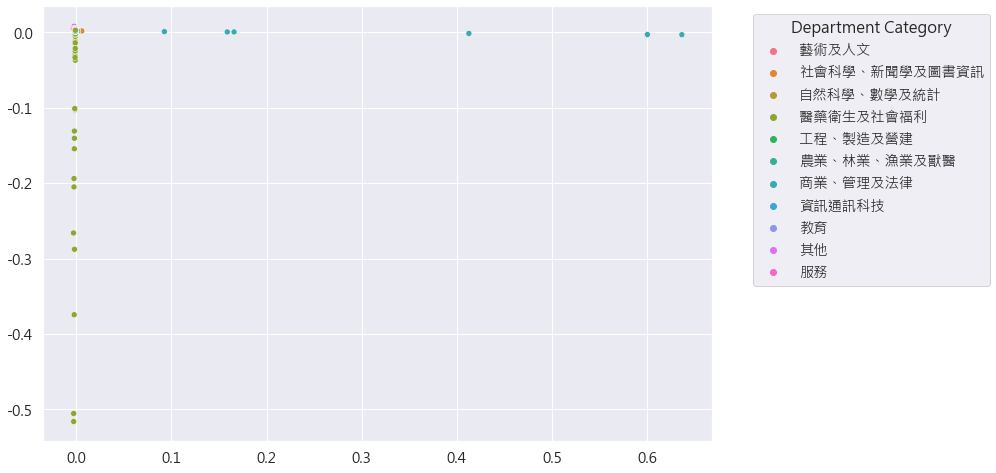

In [63]:
sns.scatterplot(x=dep_stu_lle_40[:,0], y=dep_stu_lle_40[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### (3) Perform PCA transformation first, and use the first 100 principal components as the input to LLE (with 20 neighbors)

In [46]:
pca_100 = PCA(n_components=100)
dep_stu_pca_100 = pca_100.fit_transform(dep_stu)
dep_stu_lle_pca = LocallyLinearEmbedding(n_neighbors=20).fit_transform(dep_stu_pca_100)

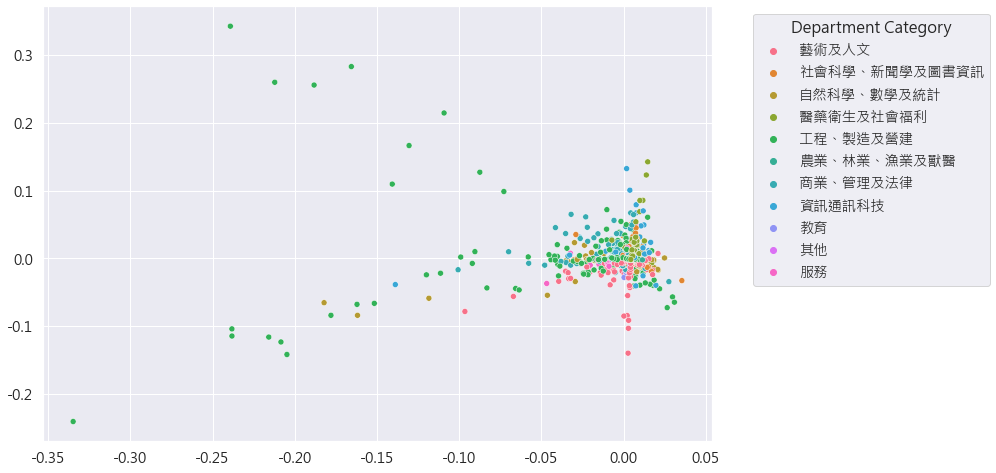

In [47]:
sns.scatterplot(x=dep_stu_lle_pca[:,0], y=dep_stu_lle_pca[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### Q2.3 Conclusion
1. 使用20個neighbor或使用40個neighbor的圖形蠻相似的，在這兩個當中都比較能分出「商業、管理及法律」與「醫藥衛生及社會福利」。
2. 根據上面的圖形來看，第三種作法似乎比第一與第二種的作法好，但好的程度也沒有說到太好，很多點還是疊在一起。

## Q2.4
Visualize academic departments using Kernel PCA. You should at least consider the RBF and Cosine kernel. It is your responsibility to select reasonably good kernel parameters. Discuss the result.

In [48]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [49]:
def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

In [50]:
param_grid = [{
        'gamma': np.linspace(0.01, 0.05, 5),
        'kernel': ["rbf", "cosine"]
    }]

kpca=KernelPCA(fit_inverse_transform=True, n_jobs=-1) 
grid_search = GridSearchCV(kpca, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(dep_stu)

GridSearchCV(cv=3, estimator=KernelPCA(fit_inverse_transform=True, n_jobs=-1),
             param_grid=[{'gamma': array([0.01, 0.02, 0.03, 0.04, 0.05]),
                          'kernel': ['rbf', 'cosine']}],
             scoring=<function my_scorer at 0x000002ABECAF59D0>)

In [51]:
grid_search.best_params_

{'gamma': 0.01, 'kernel': 'cosine'}

In [52]:
kpca = KernelPCA(n_components=2, 
                gamma=grid_search.best_params_['gamma'], 
                kernel=grid_search.best_params_['kernel'],
                n_jobs=-1)\
    .fit_transform(dep_stu)

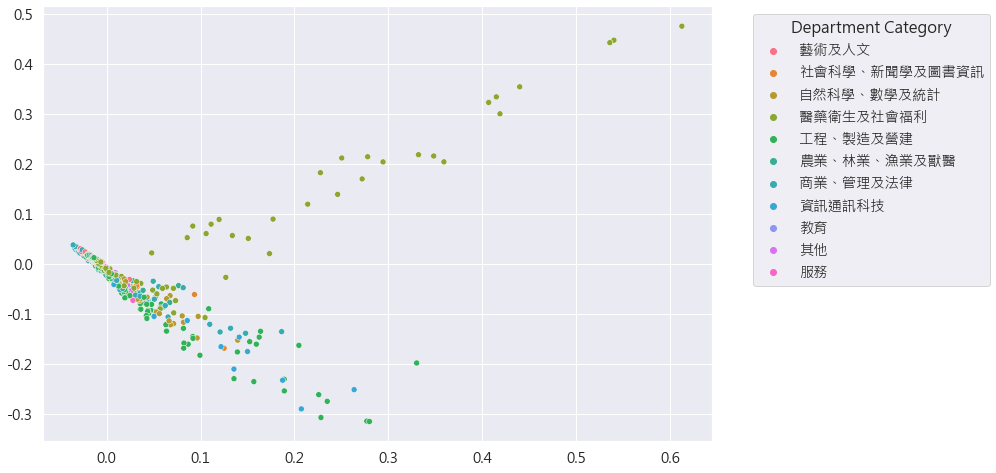

In [53]:
sns.scatterplot(x=kpca[:,0], y=kpca[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### Q2.4 Conclusion
1. 這裡我參考stackoverflow上使用GridSearchCV來找最佳參數。這裡gamma使用的是0.01~0.05共取5個點，kernel考慮rbf和cosine，結果發現比較好的kernel是cosine的，至於gamma是0.01。

    ref: https://stackoverflow.com/questions/53556359/selecting-kernel-and-hyperparameters-for-kernel-pca-reduction
2. 觀察圖形發現可以將「醫藥衛生及社會福利」和勉強的把「工程、製造及營建」和「資訊通訊科技」分出。

## Q2.5
Visualize academic departments using t-SNE. You should consider at least the Euclidian, Cosine, and Jaccard metric. Set numpy random seed so that your results can be repeated. Discuss the result.

In [54]:
from sklearn.manifold import TSNE

### Euclidian

In [55]:
tsne_Euclidian = TSNE(n_components=2, init='random', random_state=0, metric='euclidean', n_jobs=-1)\
    .fit_transform(dep_stu)

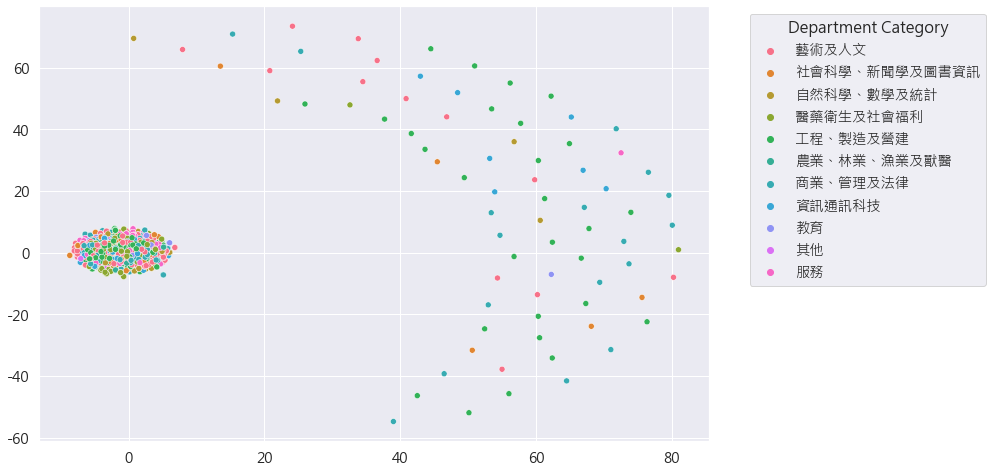

In [56]:
sns.scatterplot(x=tsne_Euclidian[:,0], y=tsne_Euclidian[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### Cosine

In [57]:
tsne_Cosine = TSNE(n_components=2, init='random', random_state=0, metric='cosine', n_jobs=-1)\
    .fit_transform(dep_stu)

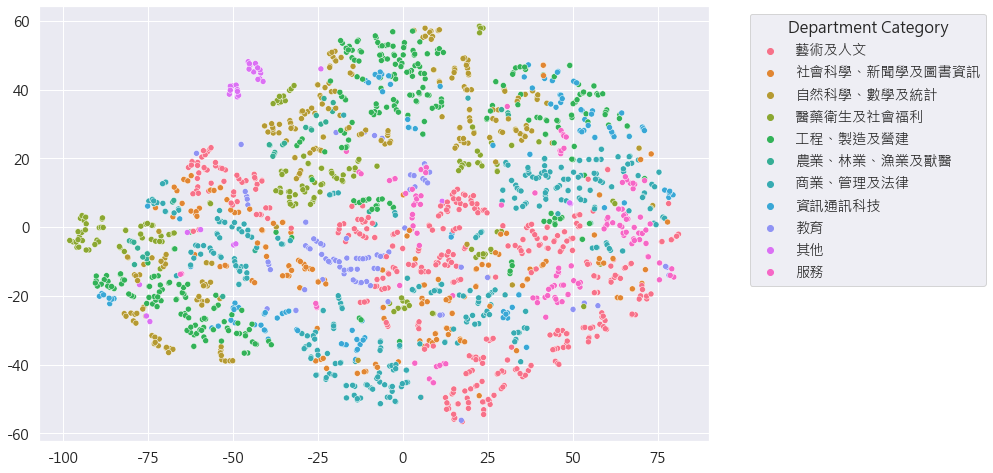

In [58]:
sns.scatterplot(x=tsne_Cosine[:,0], y=tsne_Cosine[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### Jaccard

In [59]:
tsne_Jaccard = TSNE(n_components=2, init='random', random_state=0, metric='jaccard', n_jobs=-1)\
    .fit_transform(dep_stu)

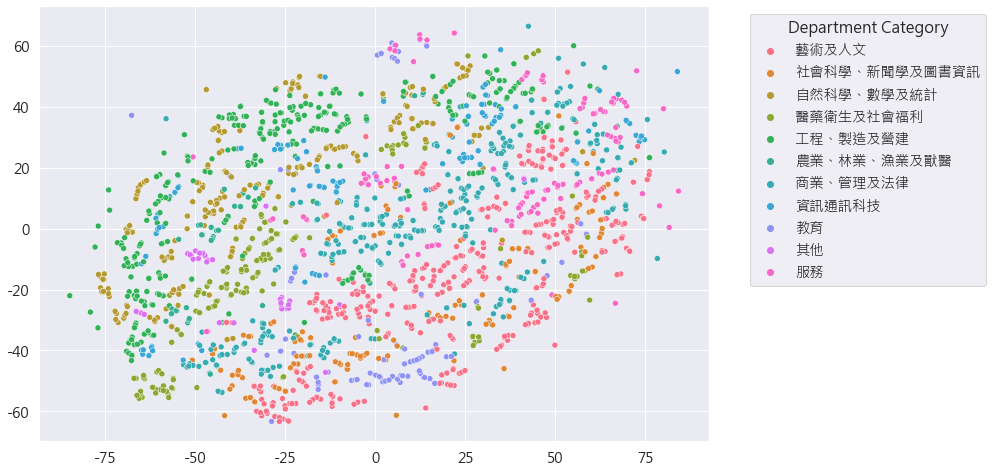

In [60]:
sns.scatterplot(x=tsne_Jaccard[:,0], y=tsne_Jaccard[:,1], hue=dep_stu_pca_cat['category_name'])\
    .legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='Department Category')

### Q2.5 Conclusion
1. 使用Euclidian做的時候可以發現外面四散的點十分隨機，而大多數的點還是集中在一起。
2. 使用Cosine與Jaccard就能明顯的看出他們能夠把學群分的集中一點。
3. 觀察Cosine的圖可以發現「自然科學、數學及統計」與「工程、製造及營建」較相近。
4. 觀察Jaccard的圖也可以發現「自然科學、數學及統計」與「工程、製造及營建」較相近。

## Q2.6
Select the most promising visualization method in the previous question and refine the result. You should color points by department category. Label each data point with its name so that we can quickly identify a data point on the picture. Moreover, you should try to reduce the problem caused by overlapping points and labels. Output an image that is large enough so that a user can easily identify a department and its neighbors. Jupyter Lab has limitations on the largest picture size. To overcome this problem, output the picture to a separate file and submit the file for grading. 

In [83]:
uname['output'] = uname['school_name_abbr'] + uname['department_name_abbr']
output = dep_category.merge(uname.loc[:,['department_id','output']], on='department_id', how='inner')
output.head()

,department_id,category_name,output
0,001012,藝術及人文,臺大中文
1,001022,藝術及人文,臺大外文
2,001032,藝術及人文,臺大歷史
3,001042,藝術及人文,臺大哲學
4,001052,藝術及人文,臺大人類學系


In [89]:
# for big picture
sns.set(style='darkgrid', font='Microsoft JhengHei', rc={'figure.figsize':(240, 160)}, font_scale=1.3)

output_picture = sns.scatterplot(x=tsne_Jaccard[:,0], y=tsne_Jaccard[:,1], hue=dep_stu_pca_cat['category_name'], y_jitter=True)
for i in range(tsne_Jaccard.shape[0]):
    plt.annotate(output.iloc[i,-1], xy=(tsne_Jaccard[i,0], tsne_Jaccard[i,1]), xytext=(tsne_Jaccard[i,0]+0.1, tsne_Jaccard[i,1]+0.1))
    
plt.savefig('output_picture.png')
plt.close()